### Required Imports and Installations

In [1]:
#!pip install xgboost
#!pip install yellowbrick
#!pip install ipywidgets
#!pip install pandas-profiling

#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

from scipy.stats import kendalltau, pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

### Data Ingestion & Pre-Processing

In [3]:
con_evs = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-EVs.sqlite"))
con_game = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Gaming.sqlite"))
con_oil = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Oil.sqlite"))
#con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech.sqlite"))
con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech2.sqlite"))
con_pnf = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-PnF.sqlite"))
#con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-stock.sqlite"))
con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb.sqlite"))
con_res = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))


cons = {
    "EVs": con_evs,
    "Gaming": con_game,
    "Oil": con_oil,
    "Tech": con_tech,
    "Pharma": con_pnf,
    "Food": con_pnf,
    "Stock": con_stock,
    "Results": con_res
}

In [4]:
tickers = {
    "EVs": ["TSLA", "LCID"],
    "Oil": ["COP", "XOM", "CVX"],
    "Pharma": ["PFE", "AZN", "MRNA"],
    "Food": ["MCD", "MDLZ", "PEP"],
    "Tech": ["GOOGL", "AAPL", "INTC", "MSFT"]
}

categories = ["EVs", "Oil", "Tech", "Pharma", "Food"]

#"Gaming": ["EA"]

#"Gaming": ["EA", "ATVI"],
#"Oil": ["COP", "XOM", "CVX", "ENB"],
#"Tech": ["GOOGL", "AAPL", "MSFT", "INTC"]

In [5]:
def load_datasets(cons, tickers, categories, reduce = False):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            if reduce == True:
                tweet_df = pd.read_sql_query(f"SELECT * from processed_tweets WHERE category='{category}'", cons["Results"])
                
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                #tweet_df["mood"] = (tweet_df["pos_counts"] - tweet_df["neg_counts"]) / tweet_df["count"]

                tweet_df.sort_values(by=['date'])

                aggregate_dict = dict()

                for idx, row in tweet_df.iterrows():
                    key = f"{row['category']},{row['date']}"

                    if key in aggregate_dict:
                        aggregate_dict[key] = aggregate_dict[key] + row

                    else:
                        aggregate_dict[key] = row


                aggregate_dict_df = pd.DataFrame.from_dict(aggregate_dict, orient='index')   
                aggregate_dict_df.reset_index(drop=True, inplace=True)   
                aggregate_dict_df['date'] = aggregate_dict_df['date'].str.slice(0, 10)

                #print(aggregate_dict_df.head())

                aggregate_dict_df.drop(columns = ['category', 'ticker'], inplace=True)
                aggregate_dict_df["date"] = aggregate_dict_df["date"].astype("datetime64")

                tweet_dfs[ticker] = aggregate_dict_df.copy(deep=True)
                
            else:
                if category in ["Pharma", "Oil", "Tech"]:    #use the new dataset results for Pharma ,Oil, Tech
                    tweet_df = pd.read_sql_query(f"SELECT * from reduced_scored_tweets WHERE category='{category}'", cons["Results"])
                else:
                    tweet_df = pd.read_sql_query(f"SELECT * from new_scored_tweets WHERE category='{category}'", cons["Results"])

                tweet_df = tweet_df.drop(columns = ['category'])
                tweet_df["date"] = tweet_df["date"].astype("datetime64")
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])
                
                
                tweet_dfs[ticker] = tweet_df.copy(deep=True)
            
            stock_df = pd.read_sql_query(f"SELECT * from stock_data WHERE ticker='{ticker}'", cons["Stock"])
            
            stock_df = stock_df.drop(columns = ['category', 'ticker'])

            stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
            stock_df["open"] = stock_df["open"].astype("float64")
            stock_df["close"] = stock_df["close"].astype("float64")
            stock_df["high"] = stock_df["high"].astype("float64")
            stock_df["low"] = stock_df["low"].astype("float64")

            stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
            
            stock_dfs[ticker] = stock_df.copy(deep=True)
            
            del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [6]:
tweet_dfs, stock_dfs = load_datasets(cons, tickers, categories, reduce = False)

In [7]:
a = tweet_dfs["PFE"]

a

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-05-01,490,1.457179,13.254883,4.287938,35.763364,323.747926,130.488703,30,340,120
1,2020-05-02,20,0.001751,0.046145,0.952104,0.035028,0.922900,19.042071,0,0,20
2,2020-05-03,60,0.942462,1.813558,0.243980,18.849234,36.271158,4.879608,20,40,0
3,2020-05-04,290,0.832914,4.385735,4.781351,17.801648,110.749017,161.449352,0,100,190
4,2020-05-05,490,0.315208,8.975050,8.709743,8.526190,250.193776,231.280041,0,240,250
...,...,...,...,...,...,...,...,...,...,...,...
739,2022-05-10,1960,16.846285,32.726631,17.427082,473.009557,967.432631,519.557781,520,1070,370
740,2022-05-11,1410,17.095188,20.703438,7.201373,544.831603,643.351742,221.816633,600,640,170
741,2022-05-12,280,3.436992,4.937239,1.625769,94.549174,132.643011,52.807821,110,130,40
742,2022-05-13,1110,12.704006,14.280140,11.015854,381.073027,425.696970,303.229994,400,450,260


In [8]:
b = stock_dfs["PFE"]

b

,date,open,close,high,low
0,2020-05-13,37.3100,37.0500,37.42500,36.58500
1,2020-05-14,36.8000,37.9200,37.96000,36.78000
2,2020-05-15,37.9600,37.7600,38.17000,37.38500
3,2020-05-16,38.1500,37.9150,38.31500,37.50750
4,2020-05-17,38.2450,37.9925,38.38750,37.56875
...,...,...,...,...,...
725,2022-05-08,48.3075,48.7400,49.18125,47.83750
726,2022-05-09,48.3800,48.6400,49.17000,47.77000
727,2022-05-10,49.0400,49.4900,49.90000,48.68500
728,2022-05-11,49.0700,49.4500,50.23500,49.03000


In [9]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
            temp_stock_df = stock_dfs[ticker].copy(deep=True)

            temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
            temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
            
            
            merged_dfs[ticker] = temp_merged_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
            
            del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [10]:
def normalize_datasets(categories, tickers, merged_dfs, reduced = False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_norm_df = merged_dfs[ticker].copy(deep=True)
            
            temp_norm_df = temp_norm_df.drop(columns=['date'])

            temp_norm_df = scaler.fit_transform(temp_norm_df)
            
            if reduced == False: #For the complete datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
            else: #For the reduced datasets
                #columns_dash = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'prev_close', 'close', 'close_delta']
                columns = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'close']
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
            
            norm_dfs[ticker] = temp_norm_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
            
            del temp_norm_df
            
    return norm_dfs

In [11]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (717, 15) 

Data dimensions for LCID: (242, 15) 

Data dimensions for COP: (719, 15) 

Data dimensions for XOM: (719, 15) 

Data dimensions for CVX: (719, 15) 

Data dimensions for GOOGL: (722, 15) 

Data dimensions for AAPL: (722, 15) 

Data dimensions for INTC: (725, 15) 

Data dimensions for MSFT: (730, 15) 

Data dimensions for PFE: (730, 15) 

Data dimensions for AZN: (730, 15) 

Data dimensions for MRNA: (730, 15) 

Data dimensions for MCD: (730, 15) 

Data dimensions for MDLZ: (730, 15) 

Data dimensions for PEP: (730, 15) 



In [12]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

Data dimensions for TSLA: (717, 14) 

Data dimensions for LCID: (242, 14) 

Data dimensions for COP: (719, 14) 

Data dimensions for XOM: (719, 14) 

Data dimensions for CVX: (719, 14) 

Data dimensions for GOOGL: (722, 14) 

Data dimensions for AAPL: (722, 14) 

Data dimensions for INTC: (725, 14) 

Data dimensions for MSFT: (730, 14) 

Data dimensions for PFE: (730, 14) 

Data dimensions for AZN: (730, 14) 

Data dimensions for MRNA: (730, 14) 

Data dimensions for MCD: (730, 14) 

Data dimensions for MDLZ: (730, 14) 

Data dimensions for PEP: (730, 14) 



In [13]:
merged_dfs['TSLA'].head()

,date,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-04-07,109.0000,109.0900,113.0000,106.468,405,29.760626,42.419716,33.819664,61.686187,105.406782,237.907026,55,92,258
1,2020-04-08,110.8400,109.7680,111.4416,106.666,243,29.776691,47.333942,25.889368,64.262435,109.520843,69.216720,71,121,51
2,2020-04-09,112.4180,114.6000,115.0364,111.422,209,29.311668,44.887577,28.800758,57.566045,100.556852,50.877107,57,118,34
3,2020-04-10,115.2250,122.3950,122.7182,113.764,272,24.159784,47.111198,29.729010,39.036394,120.448533,112.515063,39,84,149
4,2020-04-11,116.6285,126.2925,126.5591,114.935,514,29.267159,42.111918,28.620923,289.783706,153.905570,70.310696,382,68,64


In [14]:
norm_dfs['TSLA'].head()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,0.000000,0.000000,0.001377,0.000000,0.081803,0.278674,0.176300,0.143917,0.012963,0.048889,0.241882,0.012069,0.029245,0.169668
1,0.001635,0.000605,0.000000,0.000178,0.043167,0.278874,0.211060,0.100014,0.013676,0.051495,0.058898,0.016010,0.042925,0.026316
2,0.003037,0.004916,0.003175,0.004461,0.035058,0.273078,0.193756,0.116132,0.011823,0.045817,0.039005,0.012562,0.041509,0.014543
3,0.005531,0.011871,0.009961,0.006570,0.050083,0.208868,0.209484,0.121271,0.006698,0.058417,0.105865,0.008128,0.025472,0.094183
4,0.006778,0.015348,0.013354,0.007624,0.107799,0.272524,0.174122,0.115136,0.076056,0.079609,0.060085,0.092611,0.017925,0.035319


In [15]:
merged_dfs['TSLA'].describe()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,633.797699,634.884971,649.765274,618.367076,362.518828,31.380694,74.093164,55.339251,68.601300,162.239743,131.677784,67.121339,172.471409,122.926081
std,272.886468,273.336322,279.684587,266.557496,229.821472,12.196334,25.903602,21.766363,139.917803,92.487050,83.507025,158.663229,112.971202,96.808464
min,109.000000,109.090000,111.441600,106.468000,62.000000,7.401396,17.495420,7.823344,14.821995,28.221539,14.918919,6.000000,30.000000,13.000000
25%,421.390000,420.980000,430.500000,410.580000,238.000000,22.233269,53.404079,38.339832,39.921894,103.730059,82.564251,34.000000,106.000000,72.000000
50%,671.758000,670.000000,687.240000,657.510000,319.000000,29.305679,67.530556,51.607182,54.715105,143.592237,113.679667,51.000000,151.000000,101.000000
75%,823.738400,821.530000,848.180000,801.725000,437.000000,38.347519,95.472717,69.616793,73.583434,198.556858,156.864028,72.000000,214.000000,147.000000
max,1234.410000,1229.910000,1243.490000,1217.000000,4255.000000,87.635785,158.870064,188.457495,3630.055748,1606.995316,936.808373,4066.000000,2150.000000,1457.000000


c:\users\svish\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


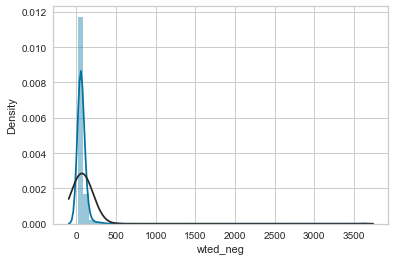

In [16]:
from scipy import stats
from scipy.stats import norm

merged_dfs['TSLA']['wted_neg'] = (merged_dfs['TSLA']['wted_neg'])

sns.distplot(merged_dfs['TSLA']['wted_neg'], fit=norm);
plt.savefig('images/TSLA-distribution.png', transparent=True, dpi=400)

#TSLA: wted_neg, ind_neg
#XOM: wted_neg
#AAPL: wted_pos, wted_neg
#MRNA: wted_neg, wted_pos, wted_neu
#PEP

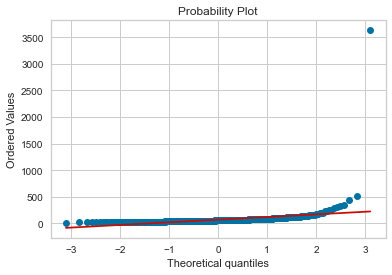

In [17]:
res = stats.probplot(merged_dfs['TSLA']['wted_neg'], plot=plt)
plt.savefig('images/TSLA-probplot.png', transparent=True, dpi=400)

c:\users\svish\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


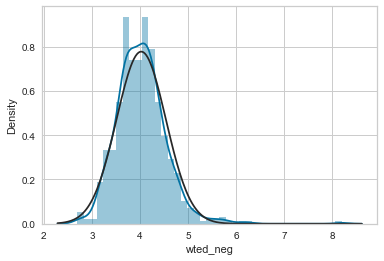

In [18]:
merged_dfs['TSLA']['wted_neg'] = np.log(merged_dfs['TSLA']['wted_neg'])

sns.distplot(merged_dfs['TSLA']['wted_neg'], fit=norm);
plt.savefig('images/TSLA-distribution-log.png', transparent=True, dpi=400)

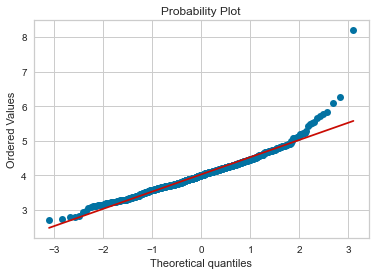

In [19]:
res = stats.probplot(merged_dfs['TSLA']['wted_neg'], plot=plt)
plt.savefig('images/TSLA-probplot-log.png', transparent=True, dpi=400)

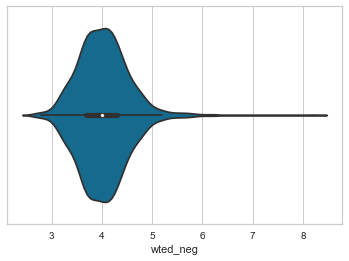

In [20]:
sns.violinplot(x='wted_neg', data=merged_dfs['TSLA'])
plt.show()

In [21]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

Data dimensions for TSLA: (717, 14) 

Data dimensions for LCID: (242, 14) 

Data dimensions for COP: (719, 14) 

Data dimensions for XOM: (719, 14) 

Data dimensions for CVX: (719, 14) 

Data dimensions for GOOGL: (722, 14) 

Data dimensions for AAPL: (722, 14) 

Data dimensions for INTC: (725, 14) 

Data dimensions for MSFT: (730, 14) 

Data dimensions for PFE: (730, 14) 

Data dimensions for AZN: (730, 14) 

Data dimensions for MRNA: (730, 14) 

Data dimensions for MCD: (730, 14) 

Data dimensions for MDLZ: (730, 14) 

Data dimensions for PEP: (730, 14) 



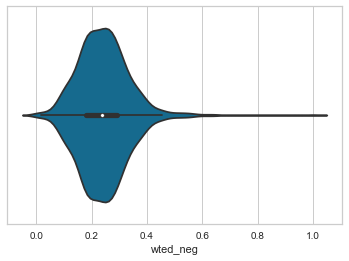

In [22]:
sns.violinplot(x='wted_neg', data=norm_dfs['TSLA'])
plt.show()

c:\users\svish\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


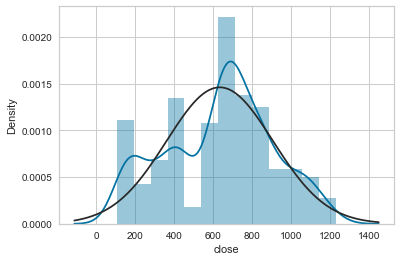

In [23]:
from scipy import stats
from scipy.stats import norm

merged_dfs['TSLA']['close'] = (merged_dfs['TSLA']['close'])

sns.distplot(merged_dfs['TSLA']['close'], fit=norm);
#plt.savefig('images/TSLA-distribution.png', transparent=True, dpi=400)

#TSLA: wted_neg, ind_neg
#XOM: wted_neg
#AAPL: wted_pos, wted_neg
#MRNA: wted_neg, wted_pos, wted_neu
#PEP

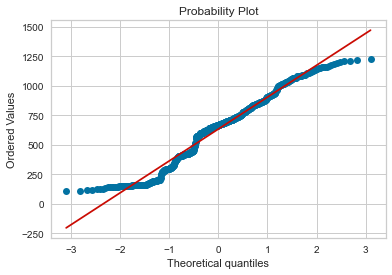

In [24]:
res = stats.probplot(merged_dfs['TSLA']['close'], plot=plt)
#plt.savefig('images/TSLA-probplot.png', transparent=True, dpi=400)

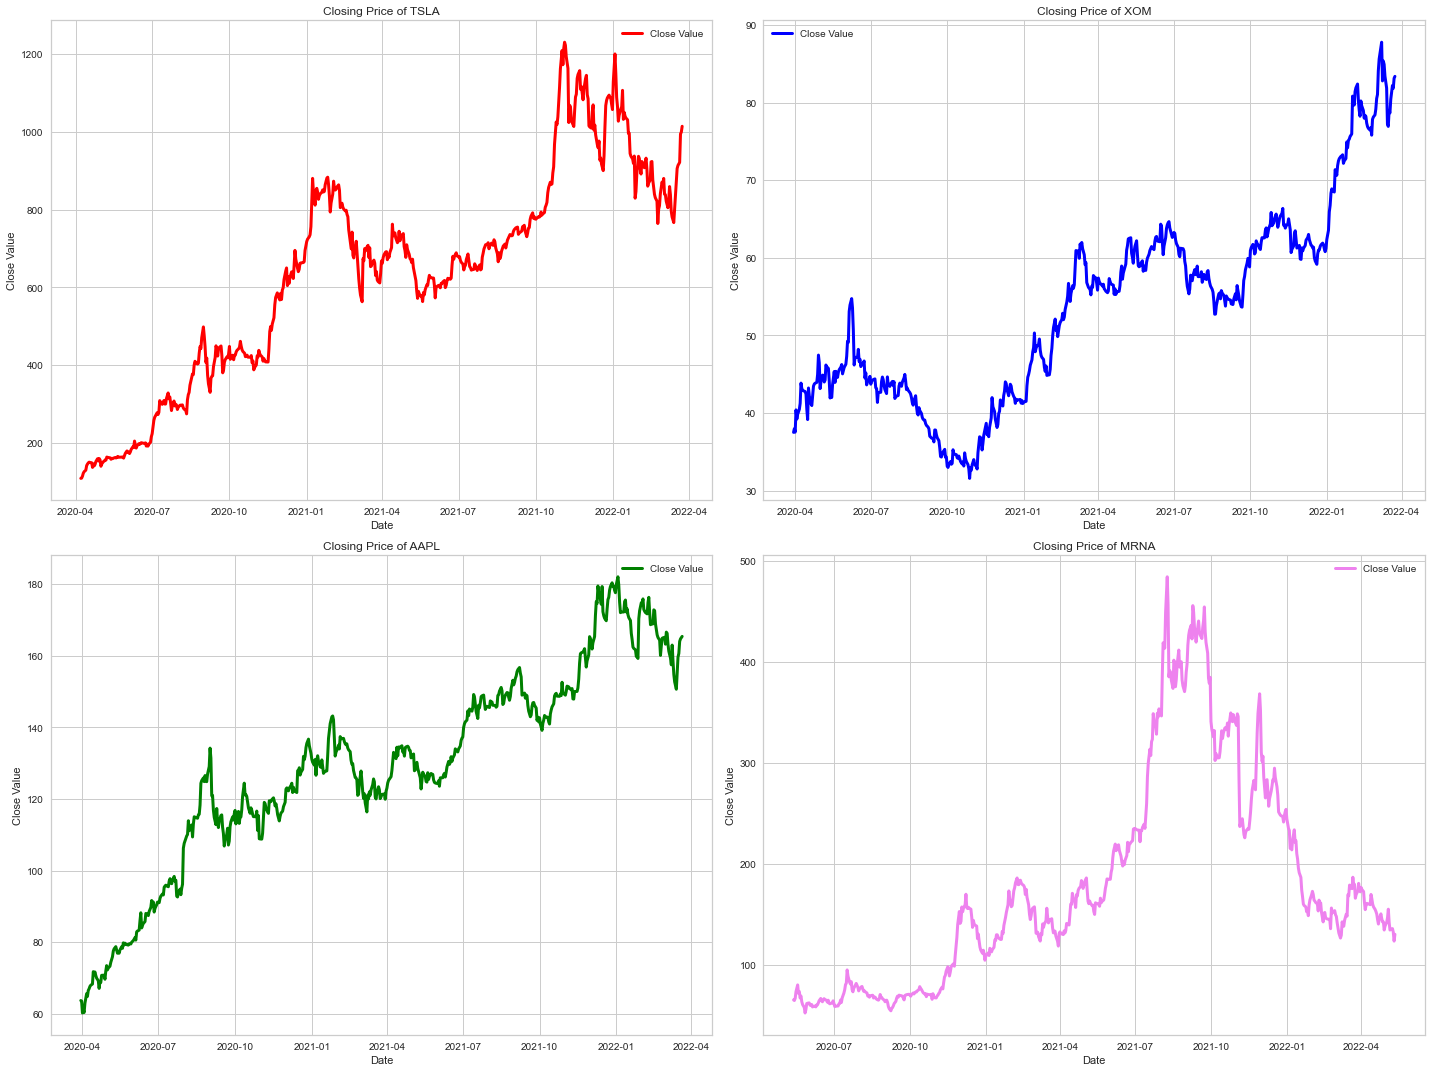

In [25]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

company_list = ['TSLA', 'XOM', 'AAPL', 'MRNA']
colors = ['red', 'blue', 'green', 'violet']

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    dates = merged_dfs[company]['date']
    close_vals = merged_dfs[company]['close']
    plt.plot(dates, close_vals, label='Close Value', linewidth=3, color=colors[i-1])
    
    plt.ylabel('Close Value')
    plt.xlabel('Date')
    plt.legend(loc='best')
    plt.title(f"Closing Price of {company_list[i - 1]}")
    
plt.tight_layout()   
plt.savefig('images/companies-close', transparent=True, dpi=400)
plt.show()

In [26]:
#from pandas_profiling import ProfileReport
#ProfileReport(merged_dfs['TSLA'])

In [27]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        for ticker in tickers[category]:
            plt.figure(figsize=(10,6))
            sns.heatmap(norm_dfs[ticker].corr('pearson'),cmap='RdYlGn',annot=True, linewidths=0.2)
            plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)
            if ticker in ['TSLA', 'XOM', 'AAPL', 'MRNA']:
                plt.savefig(f'images/correlation-heatmap-{ticker}', transparent=True, dpi=400)
            plt.show()

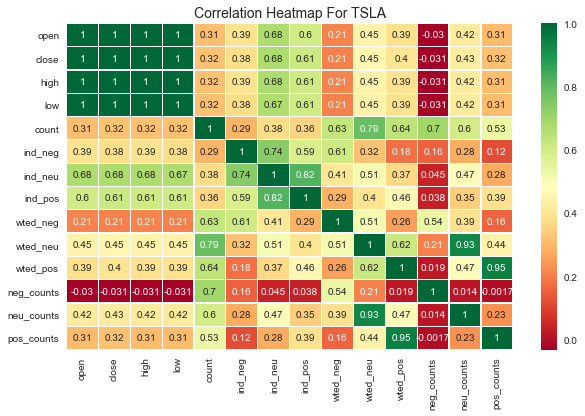

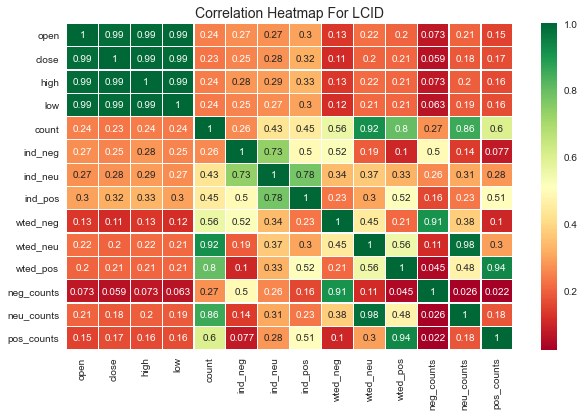

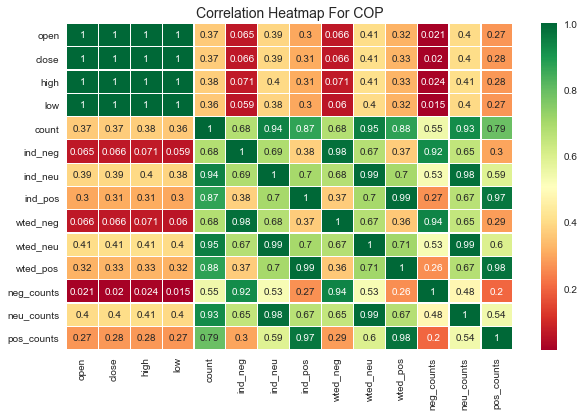

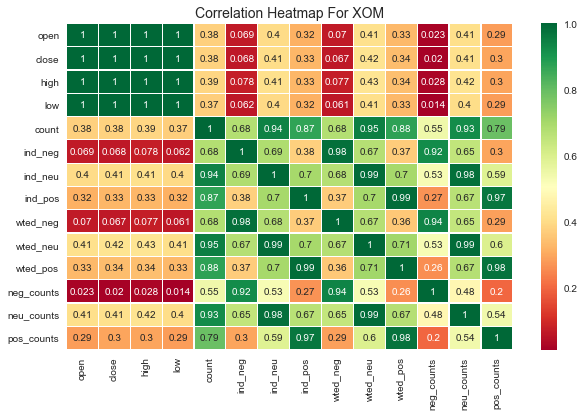

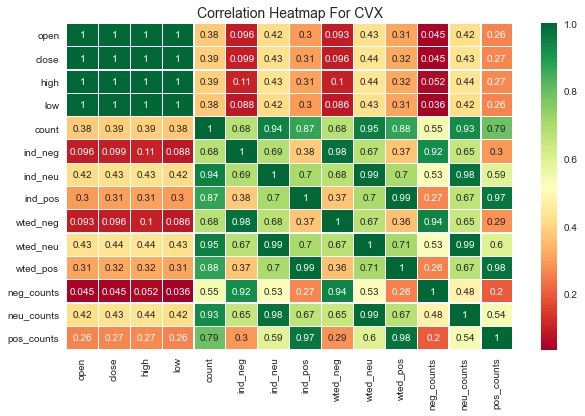

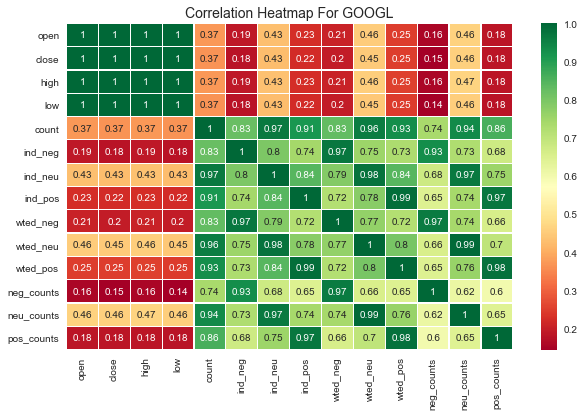

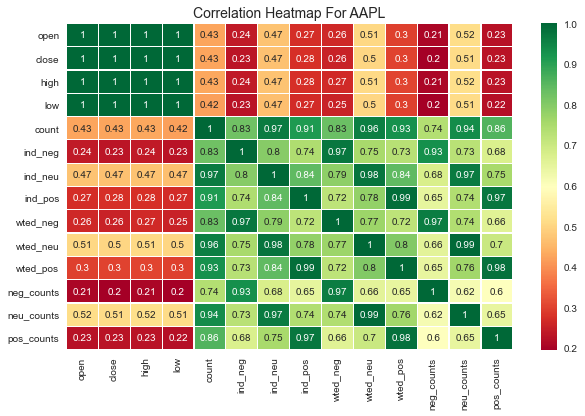

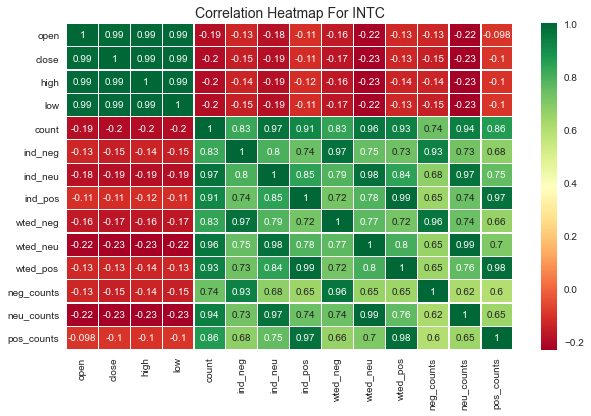

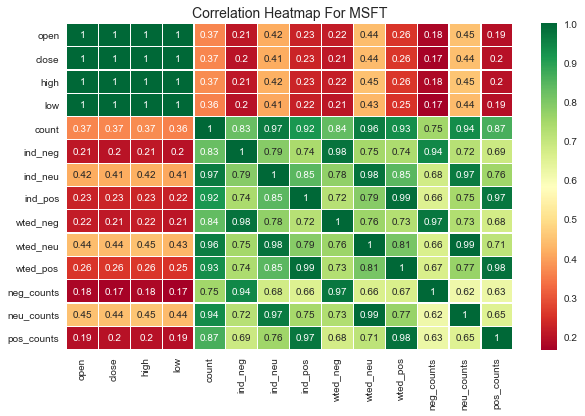

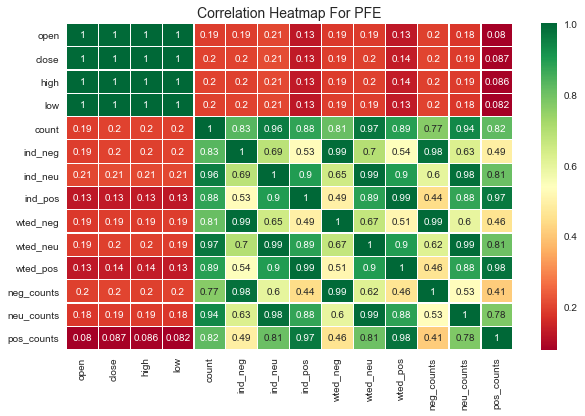

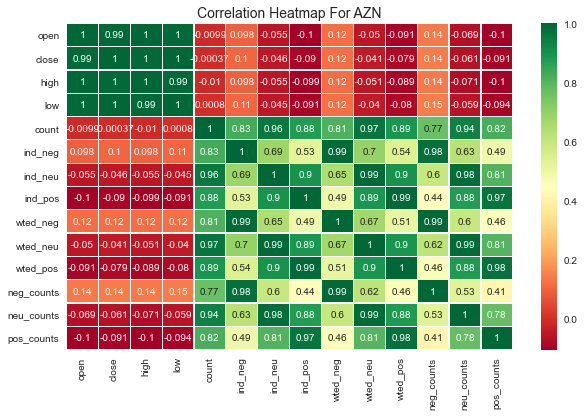

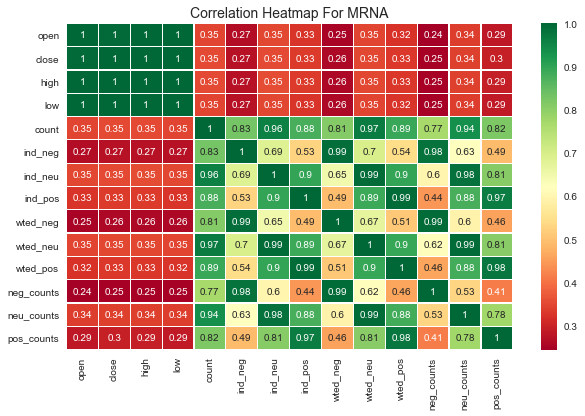

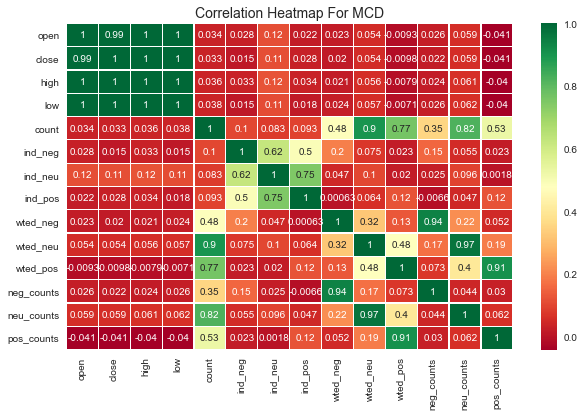

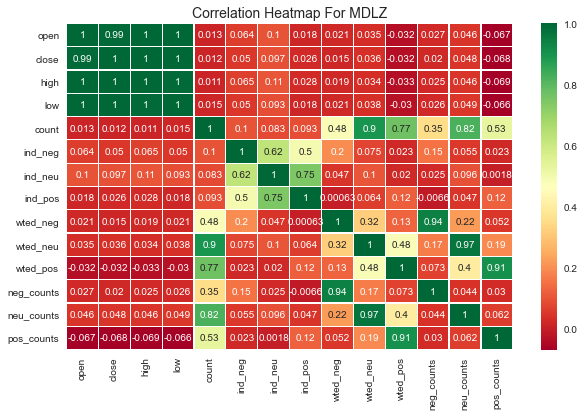

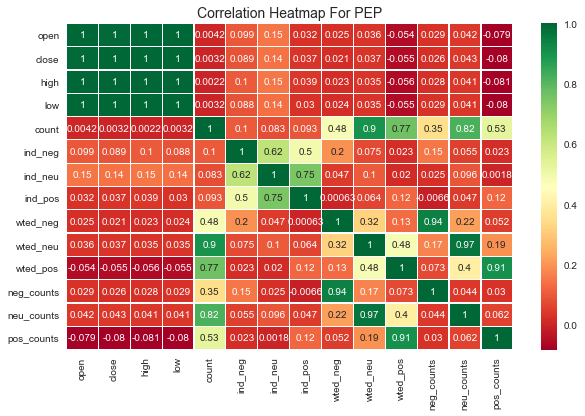

In [28]:
plot_corr_heatmaps(categories, tickers, norm_dfs)

In [29]:
#To determine the confidence levels for the correlated columns found in the correlation heatmaps

def calc_pearson_r(categories, tickers, norm_dfs):
    """
    To calculate the Pearson's correlation coefficient and determine confidence level (p > 0.05)
    """
    for category in categories:
        for ticker in tickers[category]:
            print(f"{ticker}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neg'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEG - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_neu'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_NEU - ρ: {rho}, P: {p}")
            rho, p = pearsonr(norm_dfs[ticker]['ind_pos'], norm_dfs[ticker]['close'])
            print(f"\t=====> IND_POS - ρ: {rho}, P: {p}")
            print("\n")
            
calc_pearson_r(categories, tickers, norm_dfs)

TSLA
	=====> IND_NEG - ρ: 0.3823323787182139, P: 2.2518576476764875e-26
	=====> IND_NEU - ρ: 0.6768830315257676, P: 3.156927994514375e-97
	=====> IND_POS - ρ: 0.6147949325585085, P: 9.370512803272214e-76


LCID
	=====> IND_NEG - ρ: 0.253043015120937, P: 6.861828060328372e-05
	=====> IND_NEU - ρ: 0.2760508645916776, P: 1.3181543405915005e-05
	=====> IND_POS - ρ: 0.31837515366033636, P: 4.2062976687391716e-07


COP
	=====> IND_NEG - ρ: 0.06642022607416696, P: 0.0750971419361159
	=====> IND_NEU - ρ: 0.3930115003922215, P: 5.679815481597484e-28
	=====> IND_POS - ρ: 0.3088856410499691, P: 2.3258792567076824e-17


XOM
	=====> IND_NEG - ρ: 0.06814089626803739, P: 0.06783735376034555
	=====> IND_NEU - ρ: 0.4063916222642519, P: 5.727149384345649e-30
	=====> IND_POS - ρ: 0.3265053241376578, P: 2.5362407405321963e-19


CVX
	=====> IND_NEG - ρ: 0.09924517953880821, P: 0.007741869473772299
	=====> IND_NEU - ρ: 0.4273882034310523, P: 2.7340263033170073e-33
	=====> IND_POS - ρ: 0.3064430783522911, P:

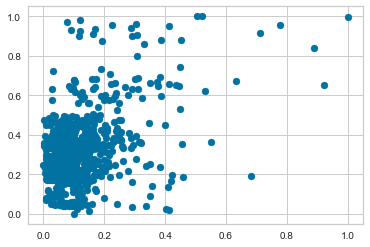

In [30]:
plt.scatter(norm_dfs["CVX"]["wted_neu"], norm_dfs["CVX"]["close"])
plt.show()

In [19]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(norm_dfs["TSLA"]["ind_neu"], norm_dfs["TSLA"]["close"], test_size=0.2, random_state=0)

X_train = X_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

reg = LinearRegression().fit(X_train, y_train)

reg.score(X_train, y_train)

0.4396178746396545

In [20]:
def add_prev_day_open(categories, tickers, merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
    
            t_df = merged_dfs[ticker].copy(deep = True)
            t_df = t_df.drop(columns = ['high', 'low', 'count', 'wted_neg', 'wted_neu', 'wted_pos', \
                                       'neg_counts', 'neu_counts', 'pos_counts'])

            t_minus1_df = t_df.copy(deep = True).drop(columns = ['close', 'ind_neg', 'ind_neu', 'ind_pos'])

            t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

            t_df = t_df.drop(columns=['open'])

            prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

            prev_open_df = prev_open_df[['date', 'open', 'ind_neg', 'ind_neu', 'ind_pos', 'close']]

            prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open'})
            
            #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
            
            prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
            
            del prev_open_df #Perform GC

    return prev_open_dfs

In [21]:
# def add_close_delta(categories, tickers, prev_open_dfs):
#     close_delta_dfs = dict()
    
#     for category in categories:
#         for ticker in tickers[category]:
    
#             t_df = prev_open_dfs[ticker].copy(deep = True)

#             t_minus1_df = t_df.copy(deep = True).drop(columns = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos'])
            
#             t_minus1_df = t_minus1_df.rename(columns = {'close': 'prev_close'})

#             t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

#             close_delta_df = pd.merge(t_df, t_minus1_df, on = ['date'])
            
#             close_delta_df['close_delta'] = (close_delta_df['close'] - close_delta_df['prev_close']) / close_delta_df['prev_close']

#             close_delta_df = close_delta_df[['date', 'prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'prev_close', 'close', 'close_delta']]
        
#             close_delta_dfs[ticker] = close_delta_df.copy(deep=True)
            
#             del close_delta_df #Perform GC

#     return close_delta_dfs

In [22]:
prev_open_dfs = add_prev_day_open(categories, tickers, merged_dfs)

prev_open_dfs['PFE']

,date,prev_open,ind_neg,ind_neu,ind_pos,close
0,2020-05-14,37.3100,5.258659,15.089359,6.651982,37.9200
1,2020-05-15,36.8000,2.549589,9.848089,7.602323,37.7600
2,2020-05-16,37.9600,0.511926,4.528185,0.959888,37.9150
3,2020-05-17,38.1500,3.110891,9.640340,4.248770,37.9925
4,2020-05-18,38.2450,19.616417,69.453575,53.930000,38.0700
...,...,...,...,...,...,...
724,2022-05-08,48.2350,22.252285,10.587381,3.160333,48.7400
725,2022-05-09,48.3075,14.403620,16.352932,8.243448,48.6400
726,2022-05-10,48.3800,16.846285,32.726631,17.427082,49.4900
727,2022-05-11,49.0400,17.095188,20.703438,7.201373,49.4500


In [23]:
# close_delta_dfs = add_close_delta(categories, tickers, prev_open_dfs)

# close_delta_dfs['PFE']

In [24]:
prev_open_norm_dfs = normalize_datasets(categories, tickers, prev_open_dfs, reduced = True)

Data dimensions for TSLA: (716, 5) 

Data dimensions for LCID: (241, 5) 

Data dimensions for COP: (712, 5) 

Data dimensions for XOM: (712, 5) 

Data dimensions for CVX: (712, 5) 

Data dimensions for GOOGL: (721, 5) 

Data dimensions for AAPL: (721, 5) 

Data dimensions for INTC: (724, 5) 

Data dimensions for MSFT: (729, 5) 

Data dimensions for PFE: (729, 5) 

Data dimensions for AZN: (729, 5) 

Data dimensions for MRNA: (729, 5) 

Data dimensions for MCD: (729, 5) 

Data dimensions for MDLZ: (729, 5) 

Data dimensions for PEP: (729, 5) 



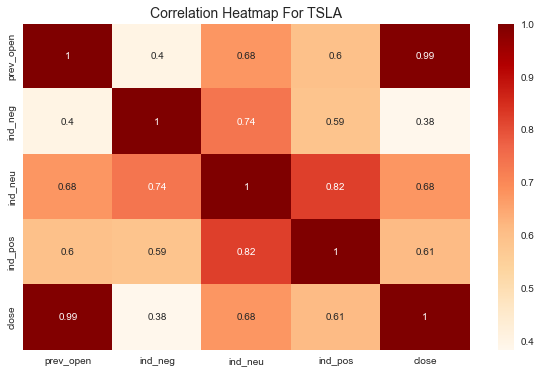

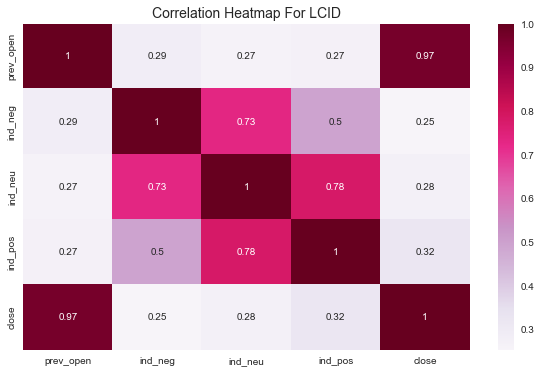

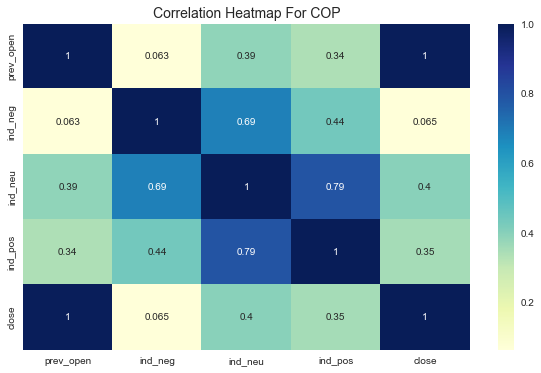

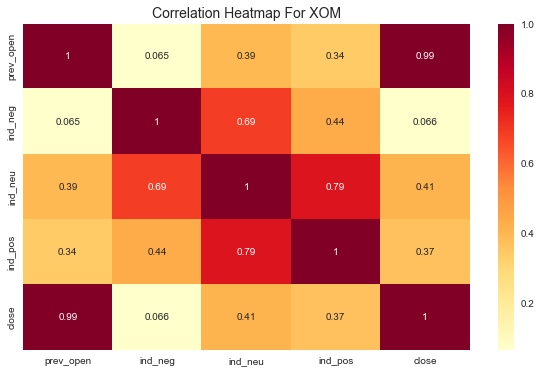

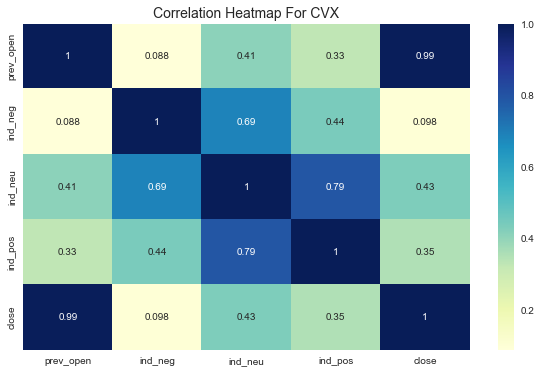

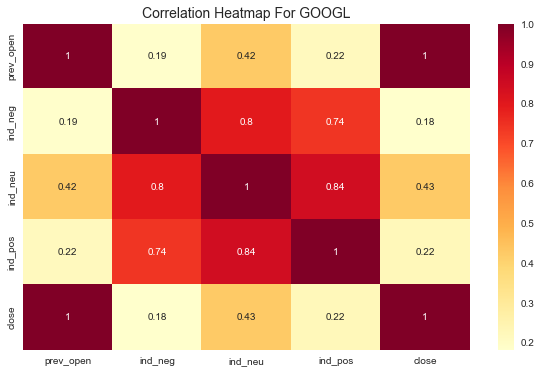

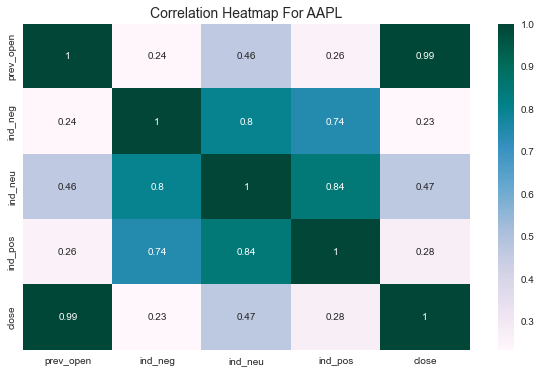

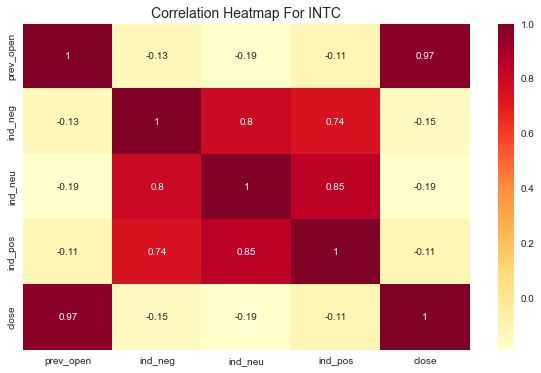

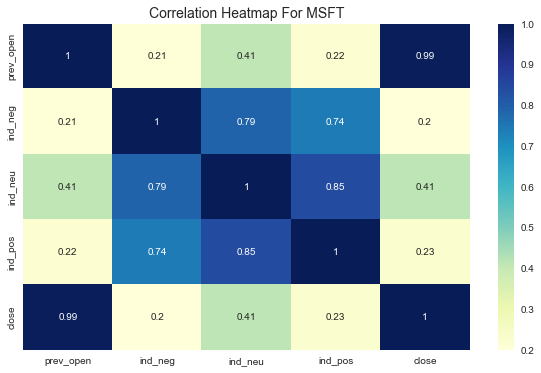

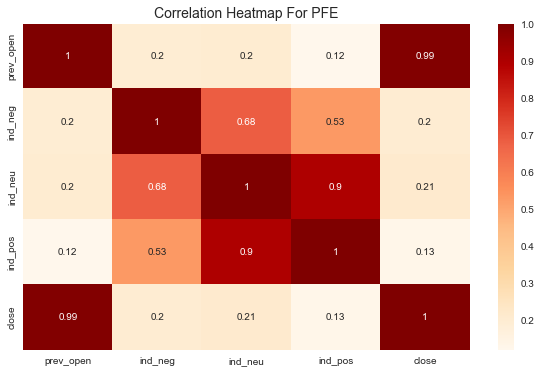

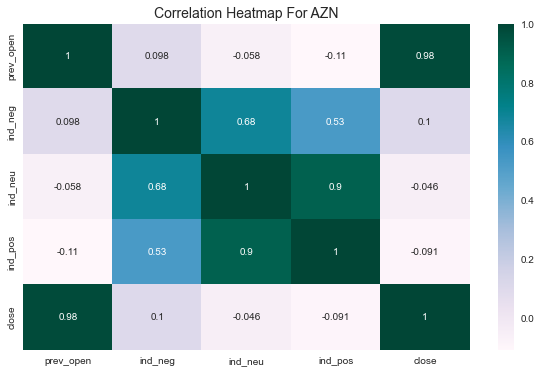

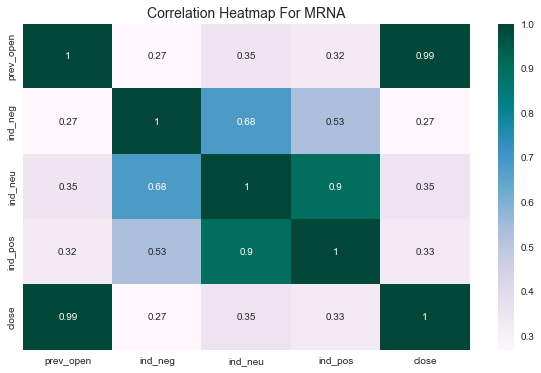

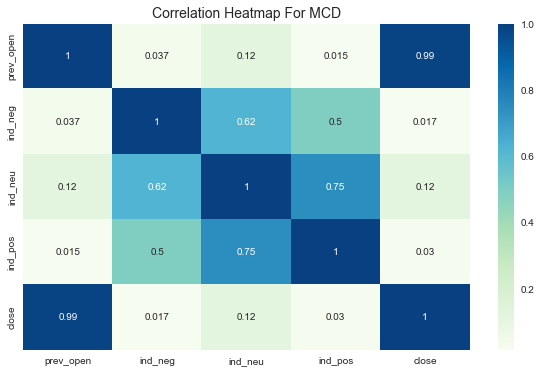

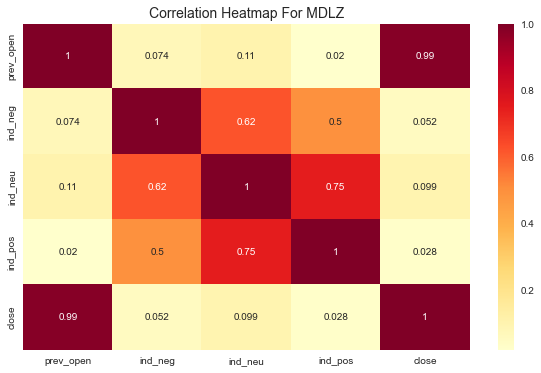

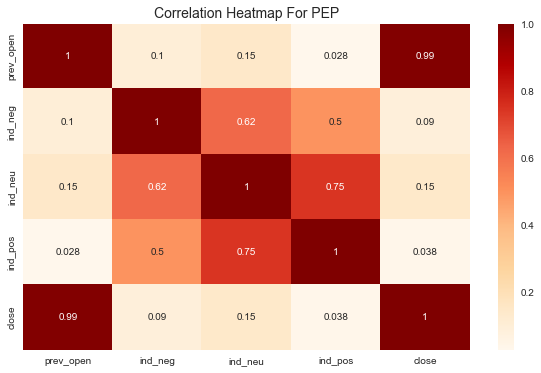

In [25]:
plot_corr_heatmaps(categories, tickers, prev_open_norm_dfs)

In [26]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [27]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    # predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [28]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
    plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [29]:
def get_train_test_set(norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = ['close'], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test

In [30]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [31]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
    model = XGBRegressor(max_depth=3, n_estimators=500, n_jobs=2,
                        objective='reg:squaredlogerror', booster='dart',
                        random_state=3, learning_rate=0.05, colsample_bytree=1, eval_metric='mae')

    
    for category in categories:
        for ticker in tickers[category]:
            print(f"======CURRENTLY WORKING ON {ticker}======")
            
            X_train, X_test, y_train, y_test = get_train_test_set(norm_dfs[ticker], output_label='close')
            
            model.fit(X_train, y_train)
            
            print_metrics(model, X_train, X_test, y_test)
            plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker])
            
            print(f"======FINISHED WORKING ON {ticker}======")

In [32]:
# """ 
# ONLY ind_neg, ind_neu, ind_pos
# Best Parameters: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'eval_metric': 'mae', 
# 'learning_rate': 0.005, 'max_depth': 12, 'n_estimators': 100, 'objective': 'reg:squarederror'}
# """

In [33]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, prev_open_dfs, output_label='close')

======CURRENTLY WORKING ON TSLA======
RMSE:			0.051812
MSE:			0.002684
MAE:			0.042728
R2 Score:		0.752482
Adj. R2 Score:		0.750736
Exp. Variance Score:	0.766020
Max Error:		0.153997


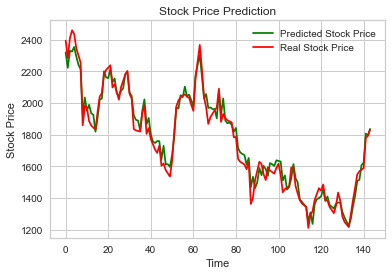

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON LCID======
RMSE:			0.055630
MSE:			0.003095
MAE:			0.045412
R2 Score:		-0.060120
Adj. R2 Score:		-0.082796
Exp. Variance Score:	0.246634
Max Error:		0.134128


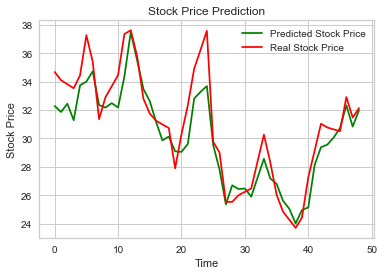

======FINISHED WORKING ON LCID======
======CURRENTLY WORKING ON COP======
RMSE:			0.171653
MSE:			0.029465
MAE:			0.126948
R2 Score:		-0.484882
Adj. R2 Score:		-0.495413
Exp. Variance Score:	0.165385
Max Error:		0.385409


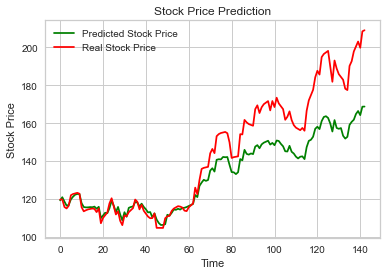

======FINISHED WORKING ON COP======
======CURRENTLY WORKING ON XOM======
RMSE:			0.193903
MSE:			0.037598
MAE:			0.143758
R2 Score:		-0.670404
Adj. R2 Score:		-0.682251
Exp. Variance Score:	0.207087
Max Error:		0.419148


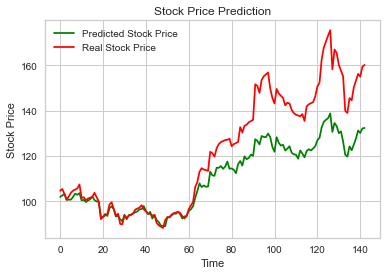

======FINISHED WORKING ON XOM======
======CURRENTLY WORKING ON CVX======
RMSE:			0.232966
MSE:			0.054273
MAE:			0.165305
R2 Score:		-1.019595
Adj. R2 Score:		-1.033919
Exp. Variance Score:	-0.004927
Max Error:		0.578314


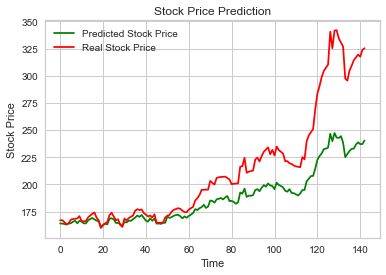

======FINISHED WORKING ON CVX======
======CURRENTLY WORKING ON GOOGL======
RMSE:			0.038725
MSE:			0.001500
MAE:			0.031695
R2 Score:		0.702809
Adj. R2 Score:		0.700728
Exp. Variance Score:	0.731622
Max Error:		0.107630


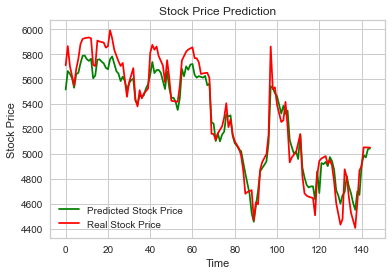

======FINISHED WORKING ON GOOGL======
======CURRENTLY WORKING ON AAPL======
RMSE:			0.132044
MSE:			0.017436
MAE:			0.113744
R2 Score:		-2.078776
Adj. R2 Score:		-2.100344
Exp. Variance Score:	0.194921
Max Error:		0.244680


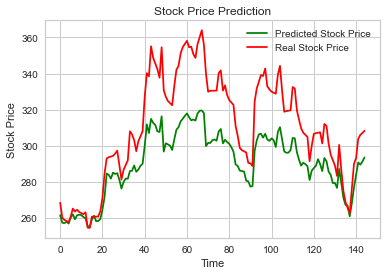

======FINISHED WORKING ON AAPL======
======CURRENTLY WORKING ON INTC======
RMSE:			0.049892
MSE:			0.002489
MAE:			0.037476
R2 Score:		0.781825
Adj. R2 Score:		0.780305
Exp. Variance Score:	0.783872
Max Error:		0.159155


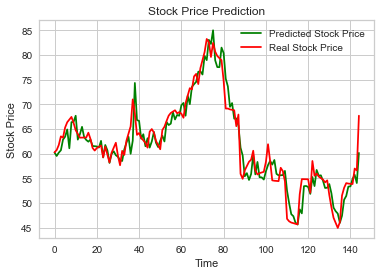

======FINISHED WORKING ON INTC======
======CURRENTLY WORKING ON MSFT======
RMSE:			0.045421
MSE:			0.002063
MAE:			0.036853
R2 Score:		0.849960
Adj. R2 Score:		0.848922
Exp. Variance Score:	0.853757
Max Error:		0.140136


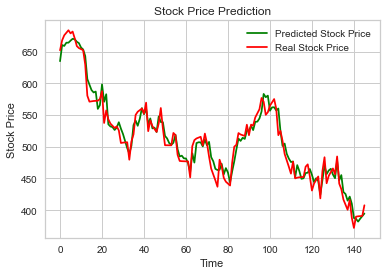

======FINISHED WORKING ON MSFT======
======CURRENTLY WORKING ON PFE======
RMSE:			0.064967
MSE:			0.004221
MAE:			0.045854
R2 Score:		0.698519
Adj. R2 Score:		0.696432
Exp. Variance Score:	0.767220
Max Error:		0.221062


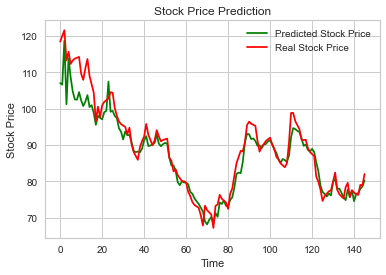

======FINISHED WORKING ON PFE======
======CURRENTLY WORKING ON AZN======
RMSE:			0.117495
MSE:			0.013805
MAE:			0.082520
R2 Score:		0.552533
Adj. R2 Score:		0.549436
Exp. Variance Score:	0.704513
Max Error:		0.333481


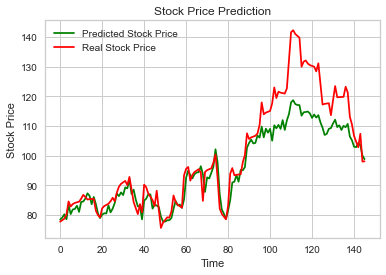

======FINISHED WORKING ON AZN======
======CURRENTLY WORKING ON MRNA======
RMSE:			0.033745
MSE:			0.001139
MAE:			0.023319
R2 Score:		0.846371
Adj. R2 Score:		0.845308
Exp. Variance Score:	0.862365
Max Error:		0.155227


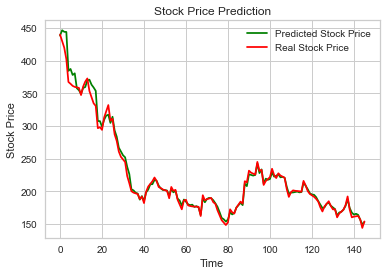

======FINISHED WORKING ON MRNA======
======CURRENTLY WORKING ON MCD======
RMSE:			0.043850
MSE:			0.001923
MAE:			0.034782
R2 Score:		0.852740
Adj. R2 Score:		0.851720
Exp. Variance Score:	0.852799
Max Error:		0.137377


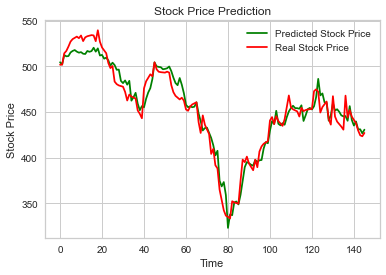

======FINISHED WORKING ON MCD======
======CURRENTLY WORKING ON MDLZ======
RMSE:			0.103835
MSE:			0.010782
MAE:			0.085407
R2 Score:		0.202327
Adj. R2 Score:		0.196806
Exp. Variance Score:	0.561771
Max Error:		0.221977


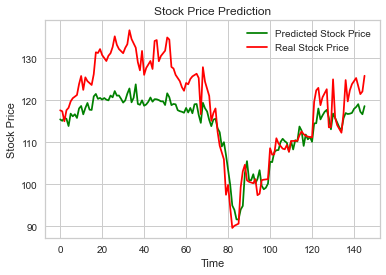

======FINISHED WORKING ON MDLZ======
======CURRENTLY WORKING ON PEP======
RMSE:			0.061193
MSE:			0.003745
MAE:			0.051590
R2 Score:		0.617957
Adj. R2 Score:		0.615313
Exp. Variance Score:	0.741714
Max Error:		0.150254


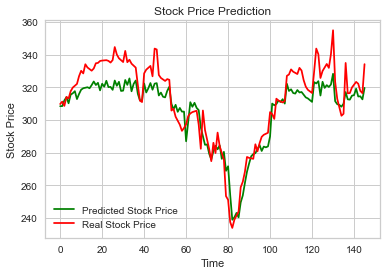

======FINISHED WORKING ON PEP======


In [34]:
train_and_test_model(categories, tickers, prev_open_norm_dfs, unscaled_op_labels)